<a href="https://colab.research.google.com/github/Ritwik-1/Fine-Tune-SAM/blob/master/SAM_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

# FINE TUNE APPROACH 1 

In [2]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint = model_checkpoint)


**FREEZING ALL IMAGE ENCODER PARAMS**

In [3]:
print(type(sam))

# Freezed all the Image encoder parameters 
for param in sam.image_encoder.parameters():
    param.requires_grad = False

<class 'segment_anything.modeling.sam.Sam'>


PARAMS IN PROMPT ENCODER

In [9]:
# IDEA : FREEZE THE POINT AND TEXT PROMPTS 
# BUT WHOLE MODULE HAS SUCH LESS PARAMS 

prompt_params = 0

for name,param in sam.prompt_encoder.named_parameters():
    # print(name)
    # print(param)
    prompt_params += param.numel()

print(prompt_params)

# Bas 6220?


6220


PARAMS IN IMAGE ENCODER

In [10]:
image_params = 0

for name,param in sam.image_encoder.named_parameters():
    # print(name)
    # print(param)
    image_params += param.numel()

print(image_params)


637026048


PARAMS IN MASK DECODER

In [11]:
mask_params = 0

for name,param in sam.mask_decoder.named_parameters():
    # print(name)
    # print(param)
    mask_params += param.numel()

print(mask_params)

4058340


In [7]:
trainable_params = 0
non_trainable_params = 0

# parameters are tensors , for getting actual no. of parameters we need to 
# count the no. of elements in each tensor 
# which is done using numel() function

for i in sam.parameters():
    if(i.requires_grad == False):
        # print(name)
        non_trainable_params+=i.numel()
    else:
        trainable_params+=i.numel()

print("Trainable params : ",trainable_params)
print("Non-trainable params : ",non_trainable_params)

Trainable params :  4064560
Non-trainable params :  637026048


**TO ADD MORE MLP LAYERS TO THE MASK DECODER**

In [18]:
# for name,param in sam.mask_decoder.named_parameters():
#     print(name)

for name,param in sam.mask_decoder.named_parameters():
  #  if(name == 'MLP'):
      print(name)


transformer.layers.0.self_attn.q_proj.weight
transformer.layers.0.self_attn.q_proj.bias
transformer.layers.0.self_attn.k_proj.weight
transformer.layers.0.self_attn.k_proj.bias
transformer.layers.0.self_attn.v_proj.weight
transformer.layers.0.self_attn.v_proj.bias
transformer.layers.0.self_attn.out_proj.weight
transformer.layers.0.self_attn.out_proj.bias
transformer.layers.0.norm1.weight
transformer.layers.0.norm1.bias
transformer.layers.0.cross_attn_token_to_image.q_proj.weight
transformer.layers.0.cross_attn_token_to_image.q_proj.bias
transformer.layers.0.cross_attn_token_to_image.k_proj.weight
transformer.layers.0.cross_attn_token_to_image.k_proj.bias
transformer.layers.0.cross_attn_token_to_image.v_proj.weight
transformer.layers.0.cross_attn_token_to_image.v_proj.bias
transformer.layers.0.cross_attn_token_to_image.out_proj.weight
transformer.layers.0.cross_attn_token_to_image.out_proj.bias
transformer.layers.0.norm2.weight
transformer.layers.0.norm2.bias
transformer.layers.0.mlp.lin

In [19]:
for name in sam.mask_decoder.children():
  #  if(name == 'MLP'):
      print(name)


TwoWayTransformer(
  (layers): ModuleList(
    (0-1): 2 x TwoWayAttentionBlock(
      (self_attn): Attention(
        (q_proj): Linear(in_features=256, out_features=256, bias=True)
        (k_proj): Linear(in_features=256, out_features=256, bias=True)
        (v_proj): Linear(in_features=256, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (cross_attn_token_to_image): Attention(
        (q_proj): Linear(in_features=256, out_features=128, bias=True)
        (k_proj): Linear(in_features=256, out_features=128, bias=True)
        (v_proj): Linear(in_features=256, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=256, out_features=2048, bias=True)
        (lin2): Linear(in

In [54]:
# Adding another MLP to the IoU prediction 

# DO NOT RUN AGAIN

import torch.nn as nn

additional_layer2 = nn.Linear(in_features=256, out_features=256,bias = True)
sam.mask_decoder.iou_prediction_head.layers.append(additional_layer2)

sam.mask_decoder.iou_prediction_head.layers.insert(1,additional_layer2)

In [72]:
# ADDING MLPs to THE OUTPUT_HYPERNETWORKS MLP MODULE

# DO NOT RUN AGAIN 

module = sam.mask_decoder.output_hypernetworks_mlps

for i in range(4):
    lin_layer = nn.Linear(in_features=256, out_features=256,bias = True)
    module[i].layers.insert(1,lin_layer)

print(module)

ModuleList(
  (0-3): 4 x MLP(
    (layers): ModuleList(
      (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=32, bias=True)
    )
  )
)


In [73]:
# SAVING THE MODEL IN THIS CONFIGURATION

# i.e 1) Image encoder is freezed 
    # 2) added 1 more MLP layer to the final output predictions

  # for now

  # Now moving to training

import torch

torch.save(sam.state_dict(), '/content/drive/MyDrive/SAM_FT1/sam.pth')

In [74]:
from segment_anything import SamPredictor

# Loading the model

# sam.load_state_dict(torch.load('/content/drive/MyDrive/SAM_FT1/sam.pth'))
# sam.eval()  # Set the model to evaluation mode if needed

device = "cuda"

sam.to(device=device)

predictor = SamPredictor(sam)

# Now take only 1 patient and make 1 train and one label

# train to pada hi hai direct and for
# test : take mask and uska box banane ki try kar
# then uska sam se pass kara and dekh output loss kya aata hai

# taking the loss function they have used for their calc

# Then if sab sahi then move to training loop and train the full set 
# and visualize on tensorboard

# DATASET PREPARATION

In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.9 MB/s eta 0:00:00


In [ ]:
from google.colab.patches import cv2_imshow

(61, 512, 512)
(512, 512)


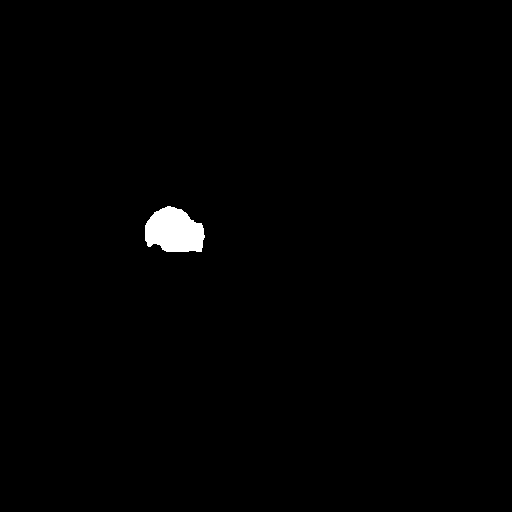

In [ ]:
import pydicom
import numpy as np
import cv2

# Load the DICOM file
dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/Patient-1-seg.dcm")

# Extract the pixel data
pixel_array = dcm.pixel_array

print(pixel_array.shape)

p = pixel_array[28]  # Extract the first channel

print(p.shape)

normalized_array = ((p - np.min(p)) / np.ptp(p) * 255).astype(np.uint8)
bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

cv2_imshow(bgr_image)
# Normalize the pixel values
# normalized_array = ((pixel_array - np.min(pixel_array)) / np.ptp(pixel_array) * 255).astype(np.uint8)

# # Convert to BGR format (assuming the segmentation map is grayscale)
# bgr_image = cv2.cvtColor(normalized_array, cv2.COLOR_GRAY2BGR)

(512, 512)
(512, 512)


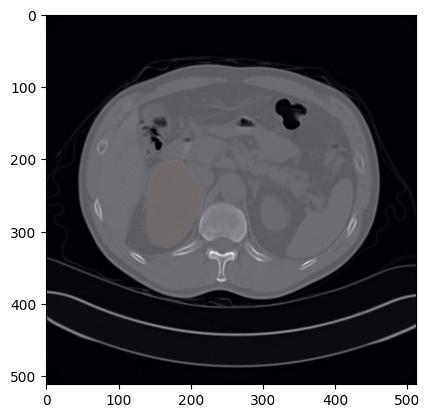

In [ ]:
import pydicom
import matplotlib.pyplot as plt

# Load the DICOM image
dcm = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/1-25.dcm")

dcm_2 = pydicom.dcmread("/content/drive/MyDrive/Colab Notebooks/assets/Patient-1-seg.dcm")
# Get the pixel data
pixels = dcm.pixel_array
p = dcm_2.pixel_array

print(p[25].shape)
print(pixels.shape)

# Display the image using matplotlib
plt.imshow(pixels, cmap=plt.cm.gray)
plt.imshow(p[36], cmap='jet', alpha=0.05) # interpolation='none'
plt.show()

